In [108]:
# import necessary library
import pandas as pd
import math
import seaborn as sns
from matplotlib import pyplot as plt
import re
import numpy as np
import geopandas as gpd
from shapely.geometry import Point # Point class
from shapely.geometry import shape
import networkx as nx
import osmnx as ox
import os 
from geopandas import GeoDataFrame, read_file
from geopandas.tools import overlay
import shapely.geometry as geom
import shapely.wkt

In [109]:
# Helper Function
def min_distance_ppoly(point, polygon):
    return polygon.distance(point).min()


# Calculate Weekly and Monthly Total Traffic

In [110]:
# Import estimated daily Volume
DV=pd.read_csv('C:/UC Berkeley Project Backup/Bike_ped Exposure Model Project/Estimated_Outcomes/Revised_Estimated_SC_DV.csv')
DV=DV.drop(['level_0','index'],axis=1)
DV.head()

,ID,year,Leg,Day of Week,month,matched_seg_id,Lat,Long,TDV
0,CH17,2019.0,E,Tuesday,3.0,89834,38.67821,-121.29246,67.478012
1,CH17,2019.0,N,Tuesday,3.0,89833,38.67821,-121.29246,41.480372
2,CH17,2019.0,S,Tuesday,3.0,89698,38.67821,-121.29246,30.248764
3,CH23,2019.0,N,Tuesday,3.0,89504,38.67837,-121.28207,36.878528
4,CH25,2019.0,S,Tuesday,3.0,bearing calculation not match with TMS count,38.67829,-121.27601,37.229248


In [111]:
check=DV.loc[DV['TDV']==0]
check

,ID,year,Leg,Day of Week,month,matched_seg_id,Lat,Long,TDV
952,Los_Gatos2,2016.0,S,Wednesday,9.0,unmatched,37.207246,-121.989509,0.0
956,Los_Gatos7,2016.0,S,Wednesday,9.0,unmatched,37.207246,-121.989509,0.0
1239,AC201624,2016.0,E,Wednesday,11.0,one-way road,37.490590,-121.948570,0.0
1248,AC201627,2016.0,E,Wednesday,11.0,one-way road,37.533410,-121.920090,0.0
1253,AC201628,2016.0,N,Thursday,10.0,150133,37.567436,-121.973156,0.0
...,...,...,...,...,...,...,...,...,...
5436,Los_Gatos2,2016.0,S,Saturday,9.0,unmatched,37.207246,-121.989509,0.0
5439,Los_Gatos3,2016.0,N,Saturday,9.0,one-way road,37.230490,-121.983220,0.0
5443,Los_Gatos4,2016.0,E,Saturday,9.0,one-way road,37.240080,-121.976810,0.0
5455,Los_Gatos6,2016.0,W,Saturday,9.0,one-way road,37.232890,-121.964340,0.0


In [113]:
DV.isnull().sum()

ID                0
year              0
Leg               0
Day of Week       0
month             0
matched_seg_id    0
Lat               0
Long              0
TDV               0
dtype: int64

In [114]:
# import pop, CBD and Strava
stv=pd.read_csv('C:/UC Berkeley Project Backup/Bike_ped Exposure Model Project/Estimated_Outcomes/Sc_Stv_pop_CBD.csv')
stv.tail(2)

,Unnamed: 0.1,ID,year,Unnamed: 0,Leg,Lat,Long,edgeUID,osmId,stv_total,stv_com_total,stv_rec_total,stv_com_ratio,stv_rec_ratio,geometry,popden
2128,2128,Eric_Fischer172,2016.0,2052,N,34.013057,-118.274009,307791126.0,13290823.0,NaN,NaN,NaN,NaN,0.0,POINT (159420.1130226079 -443267.1609445624),21037.041013
2129,2129,Eric_Fischer652,2016.0,2081,N,34.276020,-118.378320,308132385.0,578782028.0,NaN,NaN,NaN,NaN,0.0,POINT (149287.63401175514 -414268.8311619335),2486.338522


In [115]:
stv1=stv[['ID','year','stv_rec_ratio','popden']]
stv1.shape

(2130, 4)

In [116]:
DV1=pd.merge(DV,stv1, on=['ID','year'],how='inner')
DV1.shape

(5757, 11)

In [117]:
DV['ID'].nunique(),stv['ID'].nunique(),DV1['ID'].nunique()

(2114, 2129, 2104)

In [118]:
# Now find the short term sites that did not match
common = stv.merge(DV,on=['ID', 'year'])
ch=stv[(~stv.ID.isin(common.ID))]
ch.head()

,Unnamed: 0.1,ID,year,Unnamed: 0,Leg,Lat,Long,edgeUID,osmId,stv_total,stv_com_total,stv_rec_total,stv_com_ratio,stv_rec_ratio,geometry,popden
18,18,Kern2,2016.0,18,W,35.361648,-118.916461,308518564.0,10412460.0,75.0,0.0,75.0,NaN,1.000000,POINT (98373.05907189 -294466.6108904835),3819.757759
28,28,Kern92,2016.0,28,E,35.381036,-119.036808,308504507.0,10404232.0,60.0,15.0,45.0,NaN,0.750000,POINT (87425.40705098309 -292431.4765795502),1730.974240
31,31,Kern104,2016.0,31,N,35.367631,-119.065862,308496439.0,125436414.0,875.0,70.0,805.0,NaN,0.920000,POINT (84803.04972119498 -293946.6394319497),1972.054003
46,46,Kern137,2016.0,46,E,35.310406,-119.031643,308476594.0,10428508.0,65.0,15.0,50.0,NaN,0.769231,POINT (87974.35855171949 -300270.505732941),6164.919201
67,67,Kern1,2016.0,67,W,35.360320,-118.922672,308518559.0,10433051.0,125.0,35.0,90.0,NaN,0.720000,POINT (97810.85951836169 -294620.5689044185),4036.186654


In [119]:
ch['ID'].unique()

array(['Kern2', 'Kern92', 'Kern104', 'Kern137', 'Kern1', 'SLO_Co131',
       'Vista7', 'Vista8', 'Kern350', 'Kern432', 'Kern516', 'Kern627',
       'WC6', 'LA_Intx109', 'Vista18', 'Kern504', 'Vista23', 'Vista24',
       'Vista56', 'Vista65', 'Vista22', 'Vista90', 'Miovision299',
       'Miovision358', 'Vista16'], dtype=object)

In [120]:
# Lets separate sites that have Strava RR 
DV1['popden'].isnull().sum(),DV1['stv_rec_ratio'].isnull().sum()
# it seems 13 sites hass popden missing or zero pop density and 3673  have missing SRR

(18, 0)

In [121]:
DV1['popden'].fillna(1, inplace=True)

In [122]:
DV1p1=DV1.loc[DV1['stv_rec_ratio']>=0]
DV1p2=DV1[DV1['stv_rec_ratio'].isnull()]

In [123]:
DV1.shape,DV1p1.shape,DV1p2.shape 

((5757, 11), (5757, 11), (0, 11))

In [124]:
# Now estimate SRR using the formula.
# a=0.96967
# b=-0.00303
# c=0.02395
# DV1p2['stv_rec_ratio']=a+b*np.sqrt(DV1p2['popden'])+c*np.log(DV1p2['CBD Distance'])
# DV1p2.head()

In [125]:
# now combine with rest of the data that have already SRR
DV3=DV1p1
DV3.shape

(5757, 11)

In [126]:
# Now calculate the WWI index using WWI= 0.54311-0.04492* ln(population Density) + 0.60716 *〖"(Strava Recreational Ratio)" 〗^𝟐
a=0.54311
b=-0.04492
c=0.60716
DV3['WWI']=a+b*np.log(DV3['popden'])+c*np.power(DV3['stv_rec_ratio'],2)

In [127]:
# Split the data by WWI threshold to apply DOW factor
w_g1=DV3.loc[DV3['WWI']<=0.40]
w_g2=DV3.loc[DV3['WWI']>0.40]
w_g2.tail(2)

,ID,year,Leg,Day of Week,month,matched_seg_id,Lat,Long,TDV,stv_rec_ratio,popden,WWI
5755,SCC73,2018.0,S,Saturday,6.0,115615,37.04393,-122.07292,36.645619,0.912883,695.462189,0.755108
5756,SCC73,2018.0,W,Saturday,6.0,115916,37.04393,-122.07292,293.925602,0.912883,695.462189,0.755108


In [128]:
# read DOW factor
DOW=pd.read_csv('C:/UC Berkeley Project Backup/Bike_ped Exposure Model Project/Final Factor/Final_DOW_Factor.csv')
DOW.head()

,Unnamed: 0,Day of Week,Average_Group_DOW_Factor,criteria
0,0,Monday,0.157551,WWI<=0.40
1,1,Tuesday,0.172370,WWI<=0.40
2,2,Wednesday,0.168847,WWI<=0.40
3,3,Thursday,0.161830,WWI<=0.40
4,4,Friday,0.145732,WWI<=0.40


In [129]:
DOW_g1=DOW.loc[DOW['criteria']=='WWI<=0.40']
DOW_g2=DOW.loc[DOW['criteria']=='WWI>0.40']

In [130]:
# Calculate weekly Volume for group 1
wg1_DV=pd.merge(w_g1,DOW_g1, on=['Day of Week'], how='inner')
wg1_DV1=pd.DataFrame({'agge_Weekly_Volume' : wg1_DV.groupby(['ID','year','Leg','month','matched_seg_id','Lat','Long'])['TDV'].sum()}).reset_index()
wg1_DV1f=pd.DataFrame({'agge_factor' : wg1_DV.groupby(['ID','year','Leg','month','matched_seg_id','Lat','Long'])['Average_Group_DOW_Factor'].sum()}).reset_index()
wg1_DV1r=pd.merge(wg1_DV1,wg1_DV1f, on=['ID','year','Leg','month','matched_seg_id','Lat','Long'], how='inner')
wg1_DV1r['Weekly_Volume']=wg1_DV1r['agge_Weekly_Volume']/wg1_DV1r['agge_factor']
wg1_DV1rf=pd.DataFrame({'TWV' : wg1_DV1r.groupby(['ID','year','Leg','month','matched_seg_id','Lat','Long'])['Weekly_Volume'].mean()}).reset_index()

In [131]:
c=wg1_DV.loc[wg1_DV['TDV']==0]
c1=wg1_DV1.loc[wg1_DV1['agge_Weekly_Volume']==0]
c.shape,c1.shape

((22, 15), (22, 8))

In [132]:
# Calculate weekly Volume for group 2
wg2_DV=pd.merge(w_g2,DOW_g2, on=['Day of Week'], how='inner')
wg2_DV2=pd.DataFrame({'agge_Weekly_Volume' : wg2_DV.groupby(['ID','year','Leg','month','matched_seg_id','Lat','Long'])['TDV'].sum()}).reset_index()
wg2_DV2f=pd.DataFrame({'agge_factor' : wg2_DV.groupby(['ID','year','Leg','month','matched_seg_id','Lat','Long'])['Average_Group_DOW_Factor'].sum()}).reset_index()
wg2_DV2r=pd.merge(wg2_DV2,wg2_DV2f, on=['ID','year','Leg','month','matched_seg_id','Lat','Long'], how='inner')
wg2_DV2r['Weekly_Volume']=wg2_DV2r['agge_Weekly_Volume']/wg2_DV2r['agge_factor']
wg2_DV2rf=pd.DataFrame({'TWV' : wg2_DV2r.groupby(['ID','year','Leg','month','matched_seg_id','Lat','Long'])['Weekly_Volume'].mean()}).reset_index()

In [133]:
c=wg2_DV.loc[wg2_DV['TDV']==0]
c1=wg2_DV2.loc[wg2_DV2['agge_Weekly_Volume']==0]
c.shape,c1.shape

((80, 15), (75, 8))

In [134]:
wg2_DV.head()

,ID,year,Leg,Day of Week,month,matched_seg_id,Lat,Long,TDV,stv_rec_ratio,popden,WWI,Unnamed: 0,Average_Group_DOW_Factor,criteria
0,CH25,2019.0,S,Tuesday,3.0,bearing calculation not match with TMS count,38.67829,-121.27601,37.229248,0.722222,6608.877568,0.464684,1,0.130339,WWI>0.40
1,CH25,2019.0,E,Tuesday,3.0,90076,38.67829,-121.27601,45.923779,0.722222,6608.877568,0.464684,1,0.130339,WWI>0.40
2,CH25,2019.0,W,Tuesday,3.0,90104,38.67829,-121.27601,71.181857,0.722222,6608.877568,0.464684,1,0.130339,WWI>0.40
3,CH29,2019.0,N,Tuesday,3.0,89566,38.67843,-121.26712,20.196504,0.750000,6510.682560,0.490186,1,0.130339,WWI>0.40
4,CH29,2019.0,E,Tuesday,3.0,89649,38.67843,-121.26712,59.700912,0.750000,6510.682560,0.490186,1,0.130339,WWI>0.40


In [135]:
# Apply factor to obtain weekly Total Volume Volume
# wg1_DV=pd.merge(w_g1,DOW_g1, on=['Day of Week'], how='inner')
# wg1_DV['Weekly_Volume']=wg1_DV['TDV']/wg1_DV['Average_Group_DOW_Factor']
# wg1_DV1=pd.DataFrame({'TWV' : wg1_DV.groupby(['ID','year','Leg','month','matched_seg_id','Lat','Long'])['Weekly_Volume'].mean()}).reset_index()
# wg2_DV=pd.merge(w_g2,DOW_g2, on=['Day of Week'], how='inner')
# wg2_DV['Weekly_Volume']=wg2_DV['TDV']/wg2_DV['Average_Group_DOW_Factor']
# wg2_DV2=pd.DataFrame({'TWV' : wg2_DV.groupby(['ID','year','Leg','month','matched_seg_id','Lat','Long'])['Weekly_Volume'].mean()}).reset_index()


In [137]:
# c=wg2_DV2.loc[wg2_DV2['TWV']==0]
# c1=wg1_DV1.loc[wg1_DV1['TWV']==0]
# c.shape,c1.shape

In [138]:
# combine these three group of estimated daily volume together
WV=pd.concat([wg1_DV1rf,wg2_DV2rf],axis=0).reset_index()
WV.head()

,index,ID,year,Leg,month,matched_seg_id,Lat,Long,TWV
0,0,AC201610,2016.0,E,10.0,158851,37.890578,-122.293576,1132.993517
1,1,AC201610,2016.0,N,10.0,158850,37.890578,-122.293576,2171.570908
2,2,AC201610,2016.0,S,10.0,158847,37.890578,-122.293576,2407.611224
3,3,AC201610,2016.0,W,10.0,158849,37.890578,-122.293576,1132.993517
4,4,AC201623,2016.0,E,11.0,155231,37.576880,-122.027060,634.633949


In [139]:
WV['ID'].nunique()

2104

In [140]:
wg2_DV.isnull().sum()

ID                          0
year                        0
Leg                         0
Day of Week                 0
month                       0
matched_seg_id              0
Lat                         0
Long                        0
TDV                         0
stv_rec_ratio               0
popden                      0
WWI                         0
Unnamed: 0                  0
Average_Group_DOW_Factor    0
criteria                    0
dtype: int64

In [141]:
# Now divide TWV by 7 to get the weekley average volume
WV['AWV']=WV['TWV']/7
WV['year'] = WV['year'].apply(np.int64)
WV['month'] = WV['month'].apply(np.int64)
WV.head()

,index,ID,year,Leg,month,matched_seg_id,Lat,Long,TWV,AWV
0,0,AC201610,2016,E,10,158851,37.890578,-122.293576,1132.993517,161.856217
1,1,AC201610,2016,N,10,158850,37.890578,-122.293576,2171.570908,310.224415
2,2,AC201610,2016,S,10,158847,37.890578,-122.293576,2407.611224,343.944461
3,3,AC201610,2016,W,10,158849,37.890578,-122.293576,1132.993517,161.856217
4,4,AC201623,2016,E,11,155231,37.576880,-122.027060,634.633949,90.661993


In [142]:
# Now calculate the number of days in data collection month and multiple average weekly volume (AWV) to get monthly total volume
# create dummy day column to get the date and days in month
WV['day']=1
cols=["year","month","day"]
WV['date'] = WV[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")
WV['date'] = pd.to_datetime(WV['date'], errors='coerce')
WV['days_in_month'] = WV['date'].dt.days_in_month
WV.head()

,index,ID,year,Leg,month,matched_seg_id,Lat,Long,TWV,AWV,day,date,days_in_month
0,0,AC201610,2016,E,10,158851,37.890578,-122.293576,1132.993517,161.856217,1,2016-10-01,31
1,1,AC201610,2016,N,10,158850,37.890578,-122.293576,2171.570908,310.224415,1,2016-10-01,31
2,2,AC201610,2016,S,10,158847,37.890578,-122.293576,2407.611224,343.944461,1,2016-10-01,31
3,3,AC201610,2016,W,10,158849,37.890578,-122.293576,1132.993517,161.856217,1,2016-10-01,31
4,4,AC201623,2016,E,11,155231,37.576880,-122.027060,634.633949,90.661993,1,2016-11-01,30


In [143]:
WV['MTT']=WV['AWV']*WV['days_in_month']
WV['MTT'].describe()

count     5618.000000
mean      4832.742004
std       7290.621481
min          0.000000
25%       1040.984812
50%       2394.719426
75%       5309.184290
max      76472.030373
Name: MTT, dtype: float64

In [144]:
WV.isnull().sum()

index             0
ID                0
year              0
Leg               0
month             0
matched_seg_id    0
Lat               0
Long              0
TWV               0
AWV               0
day               0
date              0
days_in_month     0
MTT               0
dtype: int64

In [145]:
check=WV.loc[WV['MTT']==0]
check

,index,ID,year,Leg,month,matched_seg_id,Lat,Long,TWV,AWV,day,date,days_in_month,MTT
46,46,AC201648,2016,S,12,one-way road,37.794190,-122.271570,0.0,0.0,1,2016-12-01,31,0.0
79,79,AC201663,2016,W,1,one-way road,37.847050,-122.265410,0.0,0.0,1,2016-01-01,31,0.0
84,84,AC201666,2016,W,9,one-way road,37.692690,-121.883470,0.0,0.0,1,2016-09-01,30,0.0
116,116,AC201728,2017,W,10,one-way road,37.556060,-122.015260,0.0,0.0,1,2017-10-01,31,0.0
133,133,AC201736,2017,W,11,one-way road,37.652620,-122.094670,0.0,0.0,1,2017-11-01,30,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3272,1945,Los_Gatos3,2016,N,9,one-way road,37.230490,-121.983220,0.0,0.0,1,2016-09-01,30,0.0
3276,1949,Los_Gatos4,2016,E,9,one-way road,37.240080,-121.976810,0.0,0.0,1,2016-09-01,30,0.0
3282,1955,Los_Gatos5,2016,N,9,one-way road,37.234290,-121.973090,0.0,0.0,1,2016-09-01,30,0.0
3289,1962,Los_Gatos6,2016,W,9,one-way road,37.232890,-121.964340,0.0,0.0,1,2016-09-01,30,0.0


<AxesSubplot:>

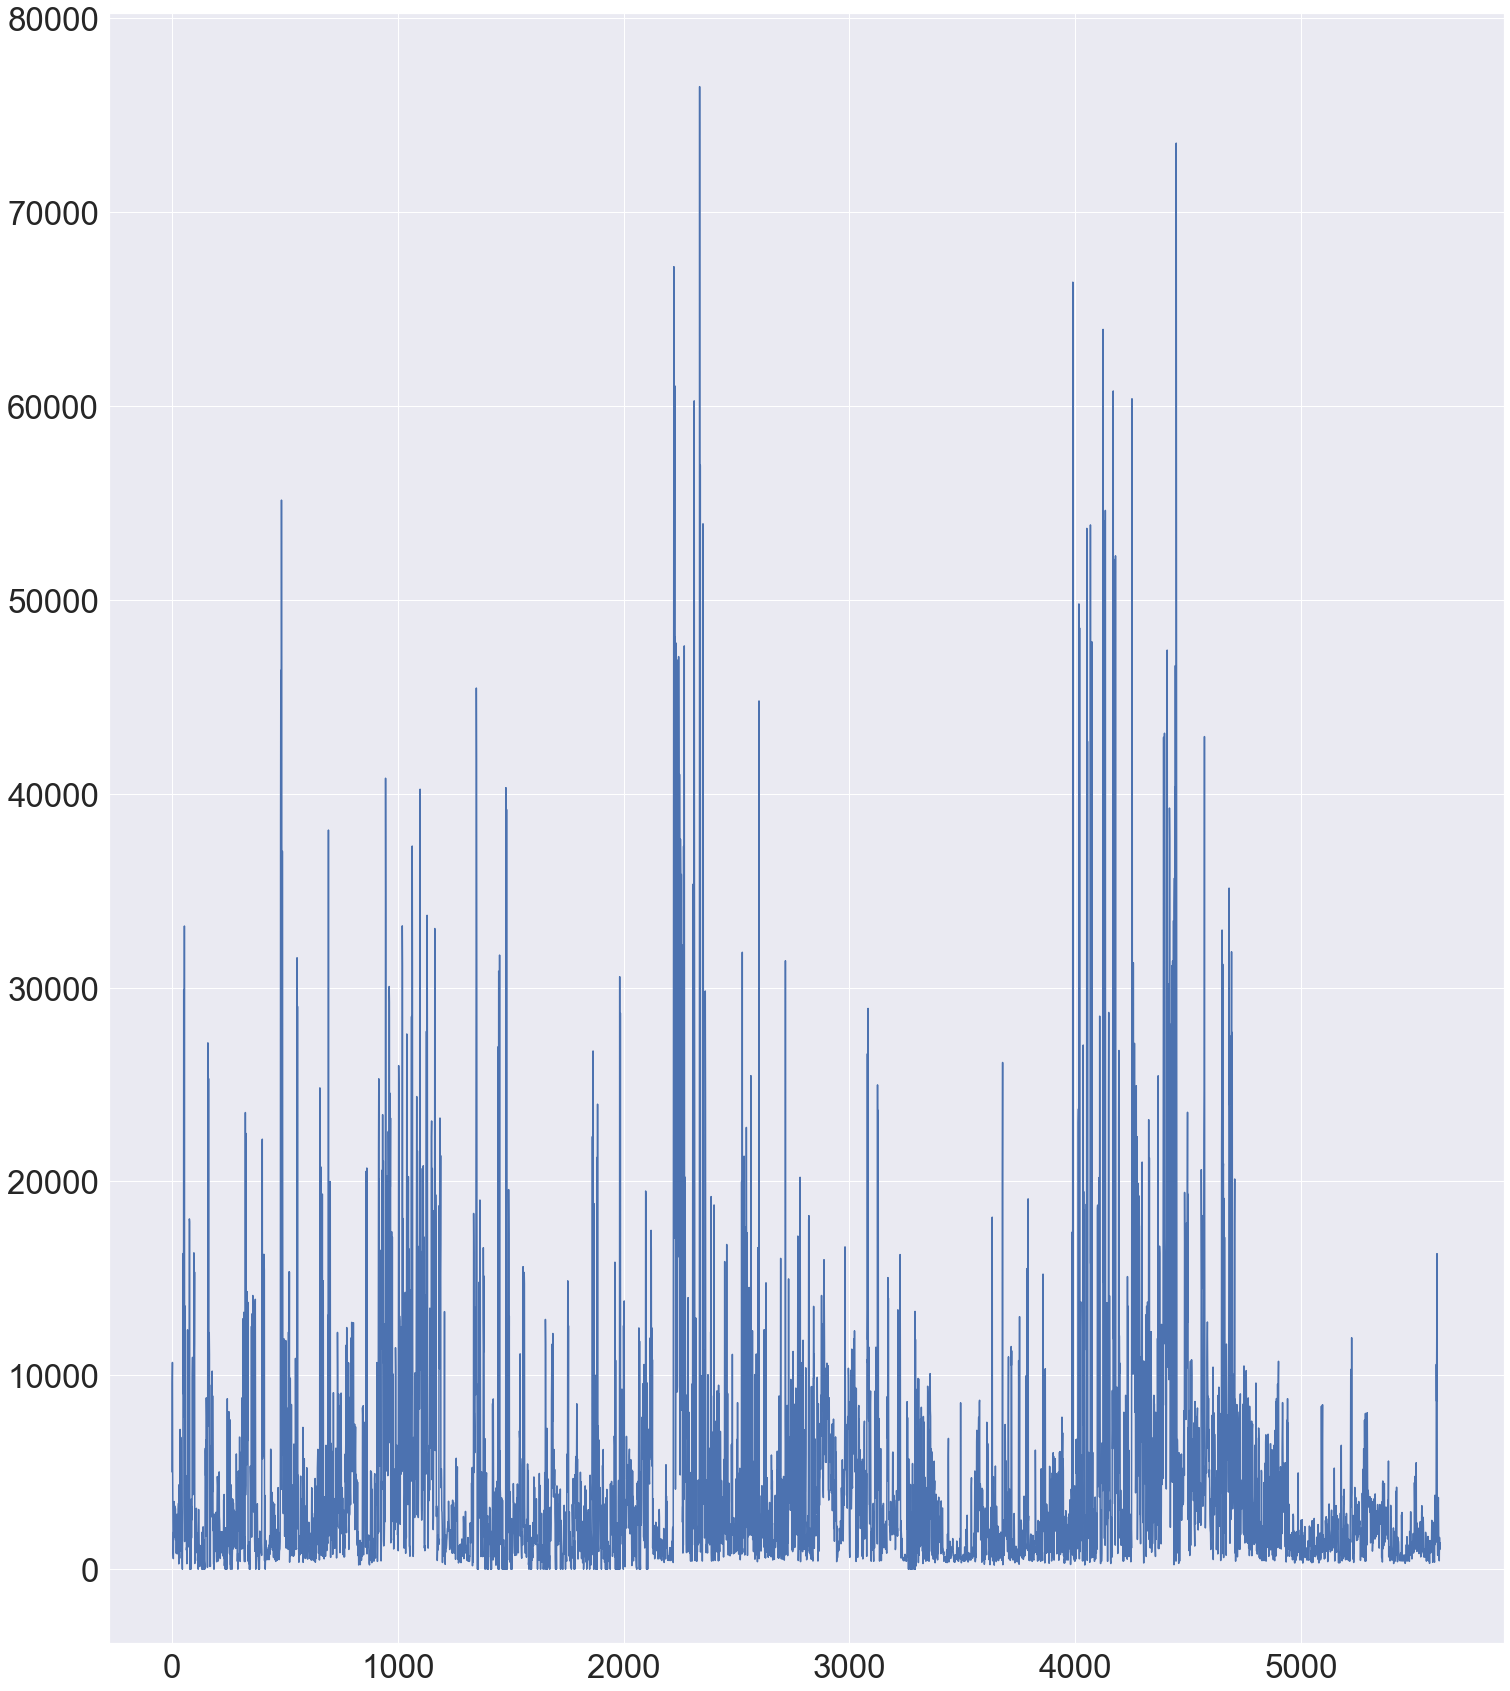

In [146]:
WV['MTT'].plot()

# Now Estimate Annual Total Traffic

In [147]:
# read the moy factor
MOY=pd.read_csv('C:/UC Berkeley Project Backup/Bike_ped Exposure Model Project/Final Factor/Final_MOY_Factor.csv')
MOY.head()

,Unnamed: 0,month,Average_Group_MOY_Factor,Criteria
0,0,1,0.067350,seasonal_factor<=2.4
1,1,2,0.070993,seasonal_factor<=2.4
2,2,3,0.080101,seasonal_factor<=2.4
3,3,4,0.087527,seasonal_factor<=2.4
4,4,5,0.091078,seasonal_factor<=2.4


In [148]:
MOY['Criteria'].unique()

array(['seasonal_factor<=2.4', '2.4<seasonal_factor<=5',
       'seasonal_factor>5'], dtype=object)

In [149]:
# Now split the data by group
moy_g1=MOY.loc[MOY['Criteria']=='seasonal_factor<=2.4']
moy_g2=MOY.loc[MOY['Criteria']=='2.4<seasonal_factor<=5']
moy_g3=MOY.loc[MOY['Criteria']=='seasonal_factor>5']
moy_g3.head(2)

,Unnamed: 0,month,Average_Group_MOY_Factor,Criteria
24,0,1,0.021449,seasonal_factor>5
25,1,2,0.018644,seasonal_factor>5


In [150]:
# Calculate the seasonality factor and check how many sites have data to calculate it
# get June/July/August Data
dos678=DV[(DV['month']>5) &(DV['month']<9)]
dos678=dos678[['ID','year','Leg','TDV']]
dos678c=pd.DataFrame({'Average Daily Count678' : dos678.groupby(['ID','year','Leg'])['TDV'].mean()}).reset_index()
dos678c.head()

,ID,year,Leg,Average Daily Count678
0,CH32,2019.0,S,19.212519
1,Eric_Fischer1007,2016.0,E,25.279441
2,Eric_Fischer1007,2016.0,N,37.919161
3,Eric_Fischer1007,2016.0,S,37.919161
4,Eric_Fischer1028,2016.0,E,218.618147


In [151]:
# get December/January/February Data
dos12=DV.loc[DV['month']==12]
dos1=DV.loc[DV['month']==1]
dos3=DV.loc[DV['month']==2]
dos1213=pd.concat([dos12,dos1,dos3],axis=0)
dos1213=dos1213[['ID','year',"Leg",'TDV']]
dos12131=pd.DataFrame({'Average Daily Count12131' : dos1213.groupby(['ID','year','Leg'])['TDV'].mean()}).reset_index()
dos12131.head()

,ID,year,Leg,Average Daily Count12131
0,AC201648,2016.0,E,91.082571
1,AC201648,2016.0,N,16.073395
2,AC201648,2016.0,S,0.000000
3,AC201648,2016.0,W,85.724773
4,AC201663,2016.0,E,40.365242


In [152]:
seasonal_data=pd.merge(dos12131,dos678c, left_on=['ID','year','Leg'],right_on=['ID','year','Leg'],how='inner')
seasonal_data['seasonal_factor']=seasonal_data['Average Daily Count678']/seasonal_data['Average Daily Count12131']
seasonal_data=seasonal_data[['ID','year','Leg','seasonal_factor']]
seasonal_data.head()

,ID,year,Leg,seasonal_factor


In [153]:
# It seems none of the sites have data to calculate the seasonality, therefore used geohrahic classification to assign the
#seasonality group. Use the closest distance to assign the seasonal group
g1=gpd.read_file('C:/UC Berkeley Project Backup/Bike_ped Exposure Model Project/Revised_Seasonality/Group1.shp')
g1['group']='seasonal_factor<=2.4'
g2=gpd.read_file('C:/UC Berkeley Project Backup/Bike_ped Exposure Model Project/Revised_Seasonality/Group2.shp')
g2['group']='2.4<seasonal_factor<=5'
g3=gpd.read_file('C:/UC Berkeley Project Backup/Bike_ped Exposure Model Project/Revised_Seasonality/Group3.shp')
g3['group']='seasonal_factor>5'
# combine all
s_g=pd.concat([g1,g2,g3],axis=0)
#s_g['group'] = s_g['group'].apply(np.int64)
s_g.head()

,Field1,ID,latitude,longitude,location,road,city,county,state,country,Average_se,geometry,group
0,0,671,37.791160,-122.459440,urban,Bay Area Ridge Trail,San Francisco,None,California,United States,1.268874,POINT (-122.45944 37.79116),seasonal_factor<=2.4
1,1,1127,37.796165,-122.419490,urban,Broadway,San Francisco,None,California,United States,1.012863,POINT (-122.41949 37.79617),seasonal_factor<=2.4
2,2,2415,37.774200,-122.436295,urban,Fell Street,San Francisco,None,California,United States,1.407406,POINT (-122.43629 37.77420),seasonal_factor<=2.4
3,3,2694,33.683254,-117.662080,urban,Torino Drive,None,Orange County,California,United States,1.359999,POINT (-117.66208 33.68325),seasonal_factor<=2.4
4,4,2695,33.672590,-117.651860,urban,Serrano Road,None,Orange County,California,United States,1.515797,POINT (-117.65186 33.67259),seasonal_factor<=2.4


In [154]:
s_g.groupby(['group'])['ID'].count()

group
2.4<seasonal_factor<=5      6
seasonal_factor<=2.4      152
seasonal_factor>5           6
Name: ID, dtype: int64

In [155]:
s_g.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [156]:
WV1 = gpd.GeoDataFrame(WV, geometry=gpd.points_from_xy(WV.Long, WV.Lat))
WV1.head()

,index,ID,year,Leg,month,matched_seg_id,Lat,Long,TWV,AWV,day,date,days_in_month,MTT,geometry
0,0,AC201610,2016,E,10,158851,37.890578,-122.293576,1132.993517,161.856217,1,2016-10-01,31,5017.542718,POINT (-122.29358 37.89058)
1,1,AC201610,2016,N,10,158850,37.890578,-122.293576,2171.570908,310.224415,1,2016-10-01,31,9616.956877,POINT (-122.29358 37.89058)
2,2,AC201610,2016,S,10,158847,37.890578,-122.293576,2407.611224,343.944461,1,2016-10-01,31,10662.278276,POINT (-122.29358 37.89058)
3,3,AC201610,2016,W,10,158849,37.890578,-122.293576,1132.993517,161.856217,1,2016-10-01,31,5017.542718,POINT (-122.29358 37.89058)
4,4,AC201623,2016,E,11,155231,37.576880,-122.027060,634.633949,90.661993,1,2016-11-01,30,2719.859780,POINT (-122.02706 37.57688)


In [157]:
crs = {'init': 'epsg:4326'}
WV2 = gpd.GeoDataFrame(WV1, crs=crs, geometry = 'geometry')
WV2.head()

C:\Users\Md Mintu Miah\anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,index,ID,year,Leg,month,matched_seg_id,Lat,Long,TWV,AWV,day,date,days_in_month,MTT,geometry
0,0,AC201610,2016,E,10,158851,37.890578,-122.293576,1132.993517,161.856217,1,2016-10-01,31,5017.542718,POINT (-122.29358 37.89058)
1,1,AC201610,2016,N,10,158850,37.890578,-122.293576,2171.570908,310.224415,1,2016-10-01,31,9616.956877,POINT (-122.29358 37.89058)
2,2,AC201610,2016,S,10,158847,37.890578,-122.293576,2407.611224,343.944461,1,2016-10-01,31,10662.278276,POINT (-122.29358 37.89058)
3,3,AC201610,2016,W,10,158849,37.890578,-122.293576,1132.993517,161.856217,1,2016-10-01,31,5017.542718,POINT (-122.29358 37.89058)
4,4,AC201623,2016,E,11,155231,37.576880,-122.027060,634.633949,90.661993,1,2016-11-01,30,2719.859780,POINT (-122.02706 37.57688)


In [158]:
# project the co-ordinate
WV2_proj = WV2.to_crs(epsg=3310).reset_index()
s_g_proj = s_g.to_crs(epsg=3310).reset_index()

In [159]:
def nearest_point(point, point2):
    idx = point2.geometry.distance(point).idxmin()
    return point2.loc[idx,'group']

In [160]:
WV2_proj['group'] = WV2_proj.geometry.apply(nearest_point, point2=s_g_proj)
WV2_proj.head()

,level_0,index,ID,year,Leg,month,matched_seg_id,Lat,Long,TWV,AWV,day,date,days_in_month,MTT,geometry,group
0,0,0,AC201610,2016,E,10,158851,37.890578,-122.293576,1132.993517,161.856217,1,2016-10-01,31,5017.542718,POINT (-201416.616 -11547.151),seasonal_factor<=2.4
1,1,1,AC201610,2016,N,10,158850,37.890578,-122.293576,2171.570908,310.224415,1,2016-10-01,31,9616.956877,POINT (-201416.616 -11547.151),seasonal_factor<=2.4
2,2,2,AC201610,2016,S,10,158847,37.890578,-122.293576,2407.611224,343.944461,1,2016-10-01,31,10662.278276,POINT (-201416.616 -11547.151),seasonal_factor<=2.4
3,3,3,AC201610,2016,W,10,158849,37.890578,-122.293576,1132.993517,161.856217,1,2016-10-01,31,5017.542718,POINT (-201416.616 -11547.151),seasonal_factor<=2.4
4,4,4,AC201623,2016,E,11,155231,37.576880,-122.027060,634.633949,90.661993,1,2016-11-01,30,2719.859780,POINT (-178761.010 -46945.065),seasonal_factor<=2.4


In [161]:
# Now split the data by group
m_g1=WV2_proj.loc[WV2_proj['group']=='seasonal_factor<=2.4']
m_g2=WV2_proj.loc[WV2_proj['group']=='2.4<seasonal_factor<=5']
m_g3=WV2_proj.loc[WV2_proj['group']=='seasonal_factor>5']
m_g3.head(2)

,level_0,index,ID,year,Leg,month,matched_seg_id,Lat,Long,TWV,AWV,day,date,days_in_month,MTT,geometry,group
892,892,892,Miovision440,2016,E,6,18189,37.369464,-118.39527,122.780195,17.540028,1,2016-06-01,30,526.200838,POINT (141911.326 -70712.549),seasonal_factor>5
893,893,893,Miovision440,2016,N,6,18180,37.369464,-118.39527,368.340586,52.620084,1,2016-06-01,30,1578.602513,POINT (141911.326 -70712.549),seasonal_factor>5


In [162]:
# Calculate Annual Volume for group 1
mg1_DV=pd.merge(m_g1,moy_g1, on=['month'], how='inner')
mg1_DV1=pd.DataFrame({'agge_monthly_Volume' : mg1_DV.groupby(['ID','year','Leg','matched_seg_id','Lat','Long'])['MTT'].sum()}).reset_index()
mg1_DV1f=pd.DataFrame({'agge_factor' : mg1_DV.groupby(['ID','year','Leg','matched_seg_id','Lat','Long'])['Average_Group_MOY_Factor'].sum()}).reset_index()
mg1_DV1r=pd.merge(mg1_DV1,mg1_DV1f, on=['ID','year','Leg','matched_seg_id','Lat','Long'], how='inner')
mg1_DV1r['Annual_Volume']=mg1_DV1r['agge_monthly_Volume']/mg1_DV1r['agge_factor']
mg1_DV1rf=pd.DataFrame({'ATT' : mg1_DV1r.groupby(['ID','year','Leg','matched_seg_id','Lat','Long'])['Annual_Volume'].mean()}).reset_index()

In [163]:
mg1_DV.shape,mg1_DV1.shape

((5166, 20), (5163, 7))

In [164]:
c=mg1_DV.loc[mg1_DV['MTT']==0]
c1=mg1_DV1.loc[mg1_DV1['agge_monthly_Volume']==0]
c.shape,c1.shape

((95, 20), (95, 7))

In [165]:
# Calculate Annual Volume for group 1
mg2_DV=pd.merge(m_g2,moy_g2, on=['month'], how='inner')
mg2_DV2=pd.DataFrame({'agge_monthly_Volume' : mg2_DV.groupby(['ID','year','Leg','matched_seg_id','Lat','Long'])['MTT'].sum()}).reset_index()
mg2_DV2f=pd.DataFrame({'agge_factor' : mg2_DV.groupby(['ID','year','Leg','matched_seg_id','Lat','Long'])['Average_Group_MOY_Factor'].sum()}).reset_index()
mg2_DV2r=pd.merge(mg2_DV2,mg2_DV2f, on=['ID','year','Leg','matched_seg_id','Lat','Long'], how='inner')
mg2_DV2r['Annual_Volume']=mg2_DV2r['agge_monthly_Volume']/mg2_DV2r['agge_factor']
mg2_DV2rf=pd.DataFrame({'ATT' : mg2_DV2r.groupby(['ID','year','Leg','matched_seg_id','Lat','Long'])['Annual_Volume'].mean()}).reset_index()

In [166]:
# Calculate Annual Volume for group 1
mg3_DV=pd.merge(m_g3,moy_g3, on=['month'], how='inner')
mg3_DV3=pd.DataFrame({'agge_monthly_Volume' : mg3_DV.groupby(['ID','year','Leg','matched_seg_id','Lat','Long'])['MTT'].sum()}).reset_index()
mg3_DV3f=pd.DataFrame({'agge_factor' : mg3_DV.groupby(['ID','year','Leg','matched_seg_id','Lat','Long'])['Average_Group_MOY_Factor'].sum()}).reset_index()
mg3_DV3r=pd.merge(mg3_DV3,mg3_DV3f, on=['ID','year','Leg','matched_seg_id','Lat','Long'], how='inner')
mg3_DV3r['Annual_Volume']=mg3_DV3r['agge_monthly_Volume']/mg3_DV3r['agge_factor']
mg3_DV3rf=pd.DataFrame({'ATT' : mg3_DV3r.groupby(['ID','year','Leg','matched_seg_id','Lat','Long'])['Annual_Volume'].mean()}).reset_index()

In [167]:
# Now apply the MOY factor to get ATT
# Apply factor to obtain daily Volume
# mg1_DV=pd.merge(m_g1,moy_g1, on=['month'], how='inner')
# mg1_DV['Annual_Volume']=mg1_DV['MTT']/mg1_DV['Average_Group_MOY_Factor']
# mg1_DV1=pd.DataFrame({'ATT' : mg1_DV.groupby(['ID','year','Leg','matched_seg_id','Lat','Long'])['Annual_Volume'].mean()}).reset_index()
# mg2_DV=pd.merge(m_g2,moy_g2, on=['month'], how='inner')
# mg2_DV['Annual_Volume']=mg2_DV['MTT']/mg2_DV['Average_Group_MOY_Factor']
# mg2_DV2=pd.DataFrame({'ATT' : mg2_DV.groupby(['ID','year','Leg','matched_seg_id','Lat','Long'])['Annual_Volume'].mean()}).reset_index()
# mg3_DV=pd.merge(m_g3,moy_g3, on=['month'], how='inner')
# mg3_DV['Annual_Volume']=mg3_DV['MTT']/mg3_DV['Average_Group_MOY_Factor']
# mg3_DV3=pd.DataFrame({'ATT' : mg3_DV.groupby(['ID','year','Leg','matched_seg_id','Lat','Long'])['Annual_Volume'].mean()}).reset_index()
# mg3_DV3.head()

In [168]:
# mg1_DV.tail(10)

In [169]:
# combine these three group of estimated Annual volume together
AV=pd.concat([mg1_DV1rf,mg2_DV2rf,mg3_DV3rf],axis=0).reset_index()
AV.ATT = AV.ATT.round()
AV.shape

(5615, 8)

In [170]:
AV=AV.loc[AV['Lat']!=0]
AV.head()

,index,ID,year,Leg,matched_seg_id,Lat,Long,ATT
0,0,AC20160,2016,E,155482,37.695501,-122.073977,48710.0
1,1,AC20160,2016,N,155481,37.695501,-122.073977,22481.0
2,2,AC20160,2016,S,155480,37.695501,-122.073977,26228.0
3,3,AC20160,2016,W,155626,37.695501,-122.073977,57453.0
4,4,AC20161,2016,E,151225,37.700510,-122.108190,1872.0


In [171]:
c=AV.loc[AV['ATT']==0]
c.shape

(97, 8)

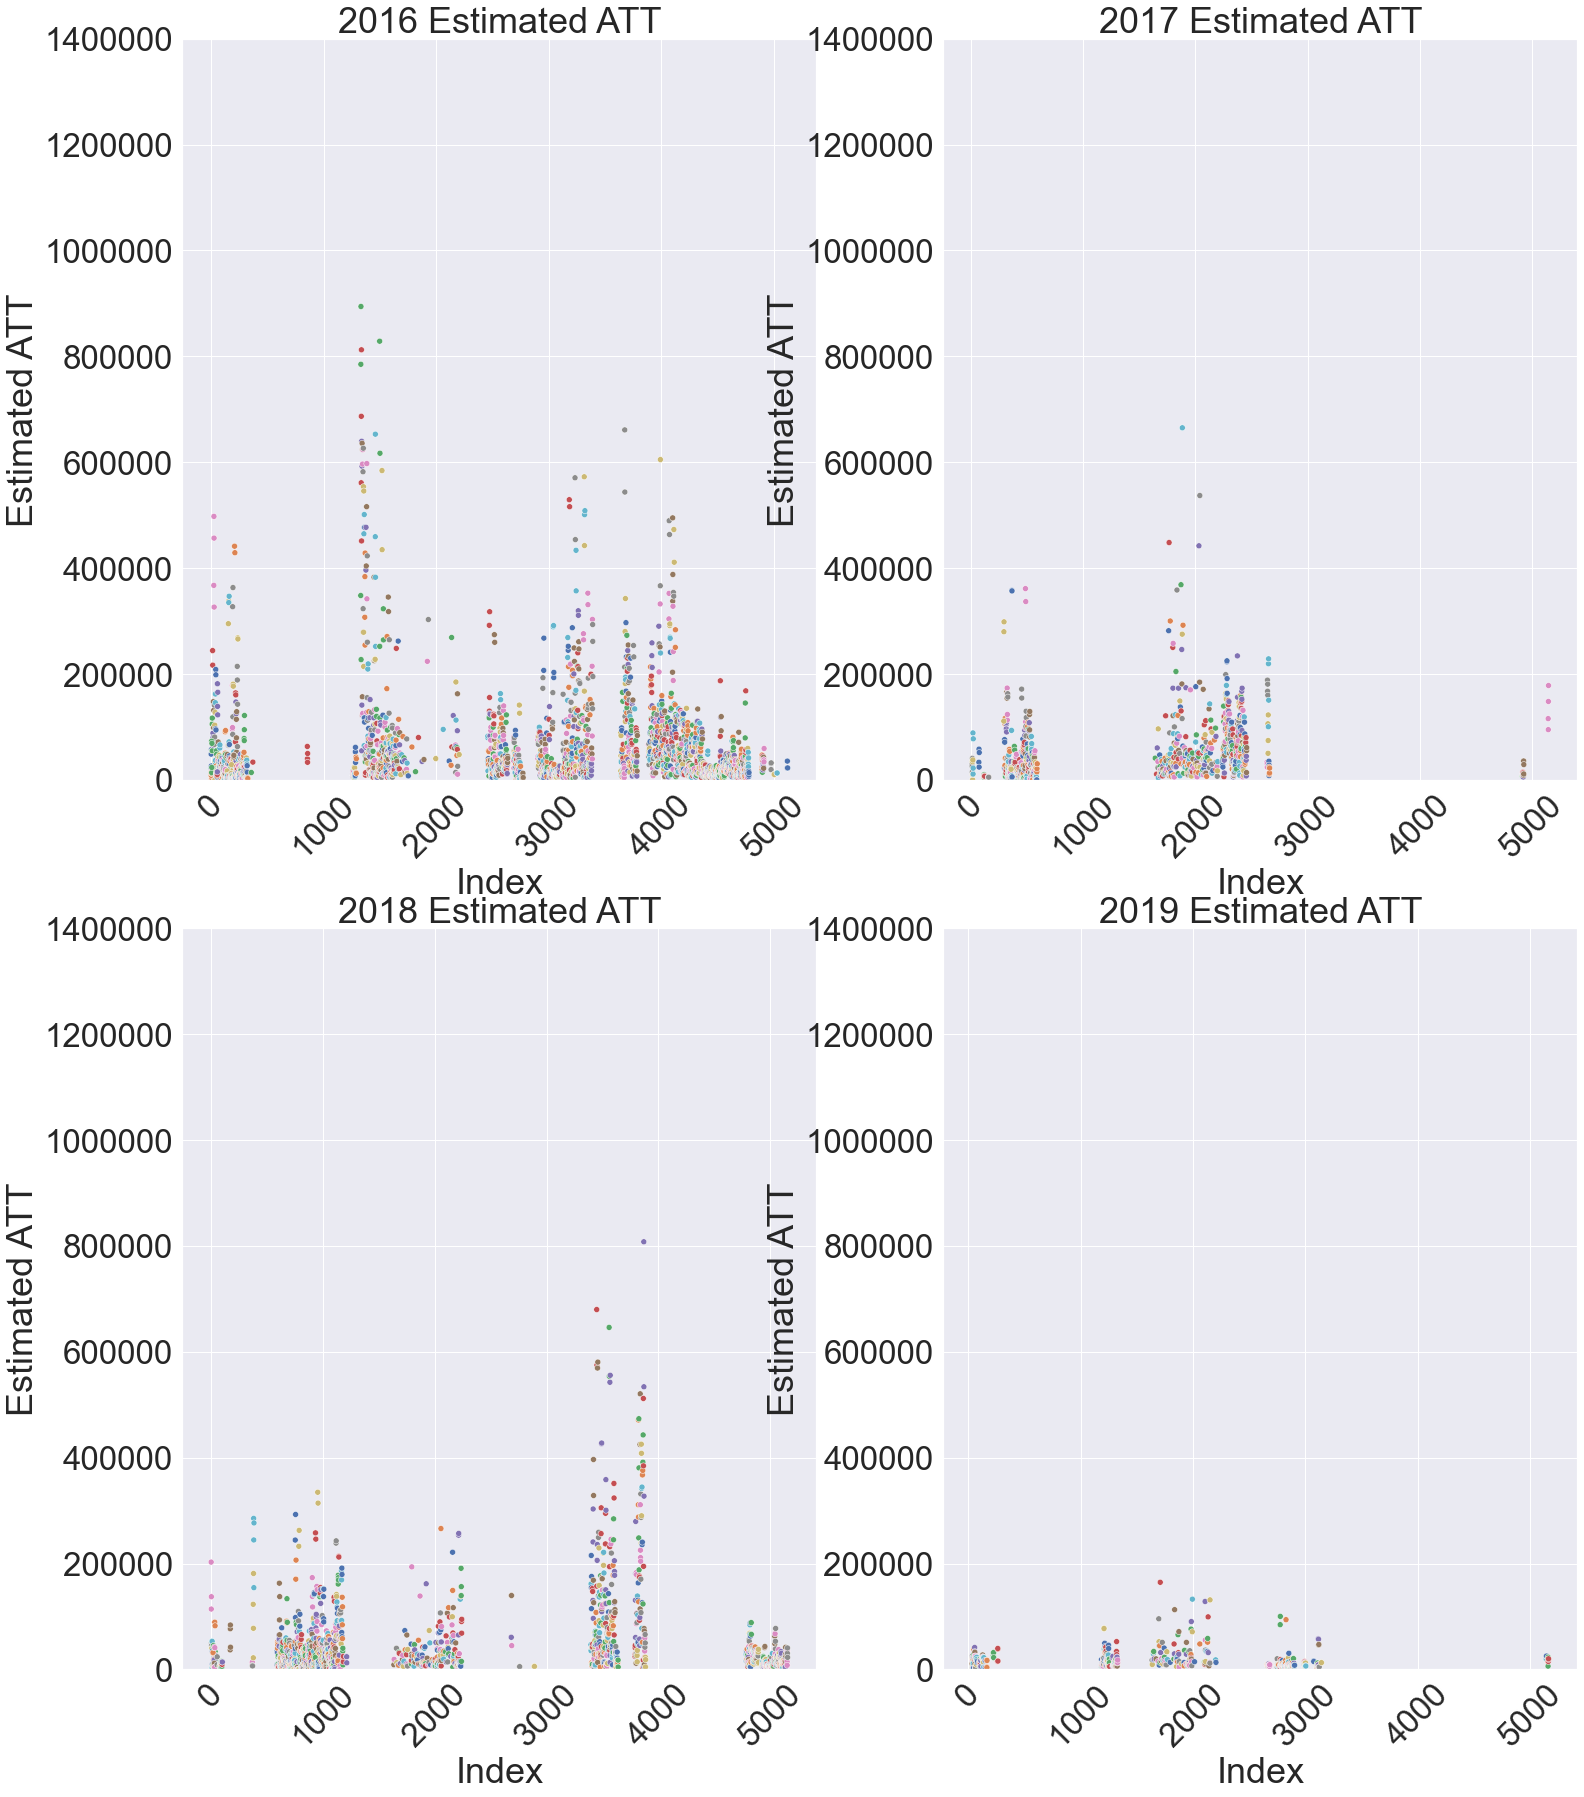

In [172]:
sns.set(rc={'figure.figsize':(25,30)})
sns.set(font_scale=3.0)
import seaborn as sns
d16=AV.loc[AV['year']==2016]
d17=AV.loc[AV['year']==2017]
d18=AV.loc[AV['year']==2018]
d19=AV.loc[AV['year']==2019]
fig, ax = plt.subplots(2,2)    
ax1 = sns.scatterplot(x=d16['index'],y=d16['ATT'],hue=d16['ID'],palette="deep",
                       markers=True,marker="o",ax=ax[0,0]) 
plt.xticks(rotation = 'vertical')
ax2 = sns.scatterplot(x=d17['index'],y=d17['ATT'],hue=d17['ID'],palette="deep",
                       markers=True,marker="o",ax=ax[0,1]) 
plt.xticks(rotation = 'vertical')
ax3 = sns.scatterplot(x=d18['index'],y=d18['ATT'],hue=d18['ID'],palette="deep",
                       markers=True,marker="o",ax=ax[1,0])
plt.xticks(rotation = 'vertical')
ax4 = sns.scatterplot(x=d19['index'],y=d19['ATT'],hue=d19['ID'],palette="deep",
                       markers=True,marker="o",ax=ax[1,1]) 
ax1.get_legend().remove()
ax2.get_legend().remove()
ax3.get_legend().remove()
ax4.get_legend().remove()
ax1.set_ylim([0, 1400000])
ax2.set_ylim([0, 1400000])
ax3.set_ylim([0, 1400000])
ax4.set_ylim([0, 1400000])
ax1.ticklabel_format(style='plain', axis='both')
ax2.ticklabel_format(style='plain', axis='both')
ax3.ticklabel_format(style='plain', axis='both')
ax4.ticklabel_format(style='plain', axis='both')
ax1.title.set_text('2016 Estimated ATT')
ax2.title.set_text('2017 Estimated ATT')
ax3.title.set_text('2018 Estimated ATT')
ax4.title.set_text('2019 Estimated ATT')
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45)
ax1.set_ylabel('Estimated ATT' )
ax1.set_xlabel('Index')
ax2.set_ylabel('Estimated ATT' )
ax2.set_xlabel('Index')
ax3.set_ylabel('Estimated ATT' )
ax3.set_xlabel('Index')
ax4.set_ylabel('Estimated ATT' )
ax4.set_xlabel('Index')
plt.show()

In [173]:
AV.groupby(['year'])['Leg'].count()

year
2016    2670
2017     855
2018    1566
2019     508
Name: Leg, dtype: int64

In [174]:
AV.groupby(['year','Leg'])['ATT'].describe()

count          mean            std     min       25%      50%  \
year Leg                                                                      
2016 E        640.0  63649.575000  104507.665167     0.0  13535.50  27054.0   
     N        651.0  62383.385561   90936.090307     0.0  13509.00  33527.0   
     S        634.0  62017.507886   85953.748552     0.0  13091.00  33527.0   
     W        613.0  64041.729201  101614.603096     0.0  12380.00  27566.0   
     unknown  132.0  76052.856061   79500.057862  5627.0  28229.50  55630.0   
2017 E        198.0  60244.207071   75854.788687     0.0  15496.75  35546.5   
     N        232.0  52798.905172   68687.160714     0.0  12875.75  30990.5   
     S        217.0  52608.230415   60393.674116     0.0  12732.00  31215.0   
     W        204.0  57375.421569   59404.973791     0.0  17887.00  35110.0   
     unknown    4.0   4947.500000     199.702278  4753.0   4807.00   4920.0   
2018 E        391.0  58384.879795   87949.998522     0.0  13211.50  28906.0   
     N        401.0  55908.900249   87015.655091     0.0  10413.00  25235.0   
     S        399.0  50012.030075   74070.370916     0.0  10490.00  23371.0   
     W        372.0  58310.169355   87992.893487     0.0  12001.00  29878.0   
     unknown    3.0  17891.666667   12004.105895  4060.0  14042.50  24025.0   
2019 E        132.0  19386.537879   19473.983528  3499.0   8240.50  13163.0   
     N        112.0  15235.026786   17392.672406  2175.0   6073.25   9505.5   
     S        118.0  17195.872881   20029.586470  2434.0   6588.00  11169.0   
     W        130.0  19141.738462   20385.027240  2481.0   7657.00  12425.5   
     unknown   16.0   9987.312500    6239.968619  4223.0   6262.75   8891.0   

                   75%       max  
year Leg                          
2016 E        61504.00  828522.0  
     N        75158.00  784888.0  
     S        75808.50  894064.0  
     W        63877.00  626423.0  
     unknown  90163.25  604945.0  
2017 E        77611.00  537007.0  
     N        68612.00  664956.0  
     S        71328.00  368603.0  
     W        77660.25  336755.0  
     unknown   5060.50    5197.0  
2018 E        62299.00  679635.0  
     N        56018.00  807621.0  
     S        49432.00  533772.0  
     W        63699.00  580405.0  
     unknown  24807.50   25590.0  
2019 E        21851.25  131297.0  
     N        16762.50  112838.0  
     S        18916.25  132668.0  
     W        22136.50  164526.0  
     unknown  10667.75   30452.0

In [175]:
AV.groupby(['year'])['ID'].count()

year
2016    2670
2017     855
2018    1566
2019     508
Name: ID, dtype: int64

In [176]:
AV.groupby(['year'])['ID'].nunique()

year
2016    894
2017    401
2018    550
2019    254
Name: ID, dtype: int64

In [177]:
AV['ID'].nunique()

2099

In [178]:
# Save the estimation
AV.to_csv('C:/UC Berkeley Project Backup/Bike_ped Exposure Model Project/Estimated_Outcomes/Revised_Estimated_SC_ATT.csv',index=False)

# end of the Script